In [3]:
# Import important libraries
import pickle
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix, classification_report
import gdown
import os
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
# Constants
train_ratio = 0.7
val_ratio = 0.15
test_ratio = 0.15

In [5]:
# Google Drive file_ids of commercial and non-commercial audio-video features
commercialFeatures_150_file_id          = "1ucT-jrkmhRHx8RSMW0bueGD2IjL3ZpiO"
nonCommercialFeatures_150_file_id       = "1uA5sdu_5b2l0z8k_aI0NeG2eqWsdX9zi"

# Destination paths
commercialFeatures_150_destination      = "commercialFeatures_150.pkl"
nonCommercialFeatures_150_destination   = "nonCommercialFeatures_150.pkl"

In [6]:
def download_file_from_google_drive(file_id, destination):
    """
    Download a file from Google Drive if it doesn't already exist locally.

    Parameters:
    - file_id (str): The unique file ID from Google Drive.
    - destination (str): The local path where the file should be saved.
    """
    if os.path.exists(destination):
        print(f'File already exists at {destination}. Skipping download.')
    else:
        url = f"https://drive.google.com/uc?id={file_id}"
        gdown.download(url, destination, quiet=False)

In [7]:
# Downloading commercialFeatures
download_file_from_google_drive(commercialFeatures_150_file_id, commercialFeatures_150_destination)

# Downloading nonCommercialFeatures
download_file_from_google_drive(nonCommercialFeatures_150_file_id, nonCommercialFeatures_150_destination)

File already exists at commercialFeatures_150.pkl. Skipping download.
File already exists at nonCommercialFeatures_150.pkl. Skipping download.


In [1]:
def load_features():
    """
    Load data from a pickled file if it exists, otherwise initialize an empty list.

    Returns:
    - commercialFeatures_150 (list) - List containing Commercial video features
    - nonCommercialFeatures_150 (list) - List containing nonCommercial video features
    """
    with open('commercialFeatures_150.pkl', 'rb') as f:
        commercialFeatures_150 = pickle.load(f)
    with open('nonCommercialFeatures_150.pkl', 'rb') as f:
        nonCommercialFeatures_150 = pickle.load(f)

    print(f'Number of commercial features: {len(commercialFeatures_150)}')
    print(f'Number of nonCommercial features: {len(nonCommercialFeatures_150)}')
    print("Audio-Visual Features Loaded Successfully")
    return commercialFeatures_150, nonCommercialFeatures_150

In [ ]:
commercialFeatures_150, nonCommercialFeatures_150 = load_features()

In [ ]:
print(commercialFeatures_150.shape)

(4364, 150, 1152)


In [ ]:
print(nonCommercialFeatures_150.shape)

(4597, 150, 1152)


# Generating labels for data and merging commercial and non-commercial features and shuffling data randomly

In [ ]:
# Generating labels
commercial_labels = np.ones(len(commercialFeatures_150))
non_commercial_labels = np.zeros(len(nonCommercialFeatures_150))

In [ ]:
# Merging commercial and non-commercial features
X = np.concatenate((commercialFeatures_150, nonCommercialFeatures_150), axis=0)
Y = np.concatenate((commercial_labels, non_commercial_labels), axis=0)

In [ ]:
print(f'Shape of data is {X.shape}')
print(f'Shape of labels is {Y.shape}')

Shape of data is (8961, 150, 1152)
Shape of labels is (8961,)


In [ ]:
# Shuffling data randomly
X, Y = shuffle(X, Y, random_state=42)

# Preprocess the data

In [ ]:
print(X[0][0])

[219.  78. 255. ... 124. 141. 177.]


In [ ]:
# Finding Range of data
maxi = 0
mini = 1000
for i in range(len(X[0][0])):
    maxi = max(maxi, X[0][0][i])
    mini = min(mini, X[0][0][i])

In [ ]:
print(f'maximum value is {maxi}')
print(f'minimum value is {mini}')

maximum value is 255.0
minimum value is 0.0


In [ ]:
def scale_data(data):
    """
    Scale the input data by dividing by 255.

    Parameters:
    data (numpy.ndarray): Input data array of shape [samples, features] or higher dimensions.

    Returns:
    numpy.ndarray: Scaled data with values in the range [0, 1].
    """

    scaled_data = data / 255.0
    return scaled_data

In [ ]:
X = scale_data(X)

In [ ]:
print(X[0][0])

[ 1.55840786 -0.51457659  3.16766892 ...  0.02947117  0.20901008
  0.56678746]


In [ ]:
def standardize_data(data):
    """
    Standardize the input data.

    Parameters:
    data (numpy.ndarray): Input data array of shape [samples, features] or higher dimensions.
                          If the input has more than 2 dimensions, the function will flatten the
                          data along the features axis, standardize, and then reshape back.

    Returns:
    numpy.ndarray: Standardized data with mean 0 and standard deviation 1 along the features axis.
    """

    original_shape = data.shape
    if len(original_shape) > 2:
        data = data.reshape(-1, original_shape[-1])

    scaler = StandardScaler()
    standardized_data = scaler.fit_transform(data)

    if len(original_shape) > 2:
        standardized_data = standardized_data.reshape(original_shape)

    return standardized_data

In [ ]:
X = standardize_data(X)

In [ ]:
print(X[0][0])

[ 1.55840786 -0.51457659  3.16766892 ...  0.02947117  0.20901008
  0.56678746]


# Train, Test and Validation split

In [ ]:
def split_data(data, labels, train_ratio=0.7, valid_ratio=0.15, test_ratio=0.15, random_state=None):
    """
    Split data into training, validation, and test sets.

    Parameters:
    data (numpy.ndarray): The input data of shape [samples, features].
    labels (numpy.ndarray): The corresponding labels of shape [samples,].
    train_ratio (float): The ratio of the training set. Default is 0.7.
    valid_ratio (float): The ratio of the validation set. Default is 0.15.
    test_ratio (float): The ratio of the test set. Default is 0.15.
    random_state (int, optional): Random seed for reproducibility.

    Returns:
    tuple: Tuple containing:
        - train_data (numpy.ndarray): Training data.
        - valid_data (numpy.ndarray): Validation data.
        - test_data (numpy.ndarray): Test data.
        - train_labels (numpy.ndarray): Training labels.
        - valid_labels (numpy.ndarray): Validation labels.
        - test_labels (numpy.ndarray): Test labels.
    """

    assert train_ratio + valid_ratio + test_ratio == 1, "Ratios must sum to 1."

    train_data, temp_data, train_labels, temp_labels = train_test_split(
        data, labels, test_size=(1 - train_ratio), random_state=random_state
    )

    temp_ratio = valid_ratio + test_ratio
    valid_ratio_relative = valid_ratio / temp_ratio
    test_ratio_relative = test_ratio / temp_ratio

    valid_data, test_data, valid_labels, test_labels = train_test_split(
        temp_data, temp_labels, test_size=test_ratio_relative, random_state=random_state
    )

    return train_data, valid_data, test_data, train_labels, valid_labels, test_labels

In [ ]:
X_train, X_val, X_test, y_train, y_val, y_test = split_data(X, Y, random_state=42)

In [ ]:
print(f'Train data shape: {X_train.shape}')
print(f'Validation data shape: {X_val.shape}')
print(f'Test data shape: {X_test.shape}')

Train data shape: (6272, 150, 1152)
Validation data shape: (1344, 150, 1152)
Test data shape: (1345, 150, 1152)


In [ ]:
print(f'Train labels shape: {y_train.shape}')
print(f'Validation labels shape: {y_val.shape}')
print(f'Test labels shape: {y_test.shape}')

Train labels shape: (6272,)
Validation labels shape: (1344,)
Test labels shape: (1345,)


# Unidirectional LSTM **Model**

In [69]:
def create_lstm_model(input_shape):
    model = Sequential()
    model.add(LSTM(256, return_sequences=True, input_shape=input_shape))
    model.add(Dropout(0.5))
    model.add(LSTM(128, return_sequences=True))
    model.add(Dropout(0.5))
    model.add(LSTM(64))
    model.add(Dropout(0.5))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [70]:
input_shape = (len(X_train[0]), len(X_train[0][0]))
uni_LSTM_Model = create_lstm_model(input_shape)
uni_LSTM_Model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_20 (LSTM)              (None, 150, 256)          1442816   
                                                                 
 dropout_20 (Dropout)        (None, 150, 256)          0         
                                                                 
 lstm_21 (LSTM)              (None, 150, 128)          197120    
                                                                 
 dropout_21 (Dropout)        (None, 150, 128)          0         
                                                                 
 lstm_22 (LSTM)              (None, 64)                49408     
                                                                 
 dropout_22 (Dropout)        (None, 64)                0         
                                                                 
 dense_12 (Dense)            (None, 32)               



## Model Training



In [71]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [72]:
history = uni_LSTM_Model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=32,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping]
)

Epoch 1/10
196/196 [==============================] - 13s 42ms/step - loss: 0.2403 - accuracy: 0.9179 - val_loss: 0.1352 - val_accuracy: 0.9568
Epoch 2/10
196/196 [==============================] - 5s 26ms/step - loss: 0.1126 - accuracy: 0.9630 - val_loss: 0.2019 - val_accuracy: 0.9457
Epoch 3/10
196/196 [==============================] - 5s 26ms/step - loss: 0.0784 - accuracy: 0.9761 - val_loss: 0.1349 - val_accuracy: 0.9606
Epoch 4/10
196/196 [==============================] - 5s 26ms/step - loss: 0.0501 - accuracy: 0.9842 - val_loss: 0.1269 - val_accuracy: 0.9658
Epoch 5/10
196/196 [==============================] - 5s 26ms/step - loss: 0.0237 - accuracy: 0.9927 - val_loss: 0.1670 - val_accuracy: 0.9621
Epoch 6/10
196/196 [==============================] - 5s 26ms/step - loss: 0.0124 - accuracy: 0.9970 - val_loss: 0.1922 - val_accuracy: 0.9621
Epoch 7/10
196/196 [==============================] - 5s 26ms/step - loss: 0.0140 - accuracy: 0.9960 - val_loss: 0.1574 - val_accuracy: 0.965

## Evaluating model on Test data

In [73]:
test_loss, test_accuracy = uni_LSTM_Model.evaluate(X_test, y_test)

43/43 [==============================] - 2s 14ms/step - loss: 0.1019 - accuracy: 0.9710


In [74]:
print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_accuracy}')

Test Loss: 0.10186314582824707
Test Accuracy: 0.9710037112236023


In [75]:
y_pred = (uni_LSTM_Model.predict(X_test) > 0.5).astype("int32")

43/43 [==============================] - 2s 13ms/step


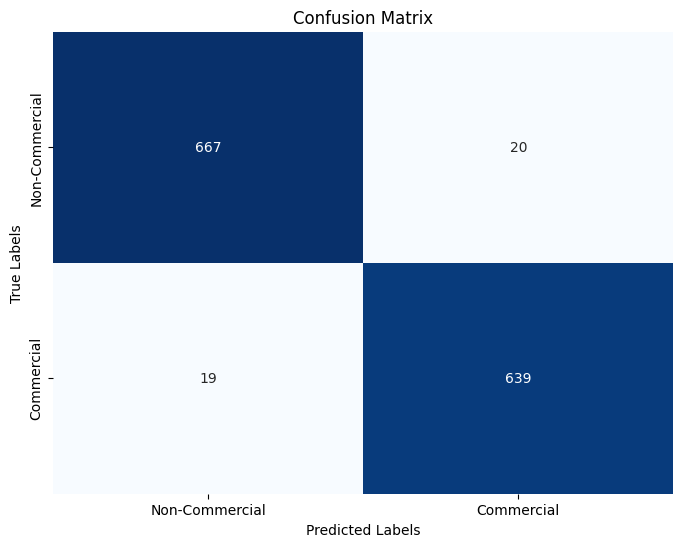

In [77]:
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='g', cbar=False,
            xticklabels=['Non-Commercial', 'Commercial'],
            yticklabels=['Non-Commercial', 'Commercial'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [81]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.97      0.97      0.97       687
         1.0       0.97      0.97      0.97       658

    accuracy                           0.97      1345
   macro avg       0.97      0.97      0.97      1345
weighted avg       0.97      0.97      0.97      1345



## Exporting the trained uni_LSTM model

In [84]:
uni_LSTM_Model.save('./uni_LSTM_Model.keras')